# Animal classification AI
# Final model

## TOC
- Student info
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading the data
   - 1.a: Saving the labels
   - 1.b: Saving dictionary of file paths
- Step 2: Data analysis
   - 2.a: showing some images
- Step 3: Choosing the descriptor
   - 3.a: Loading in the pickle data
   - 3.b: Encoding the images
   - 3.c: Validate loaded data
- Step 4: Making validation set(s) and test set(s)
- Step 5: Making the model
- Step 6: Analysing the model
- Step 7: Making a submission
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [2]:
# general optima
optima_test_fraction = 0.15
optima_test_fraction_balanced = True
optima_descriptor = "sift"
optima_clusters = 100

In [35]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np
from collections import Counter 

# handle images - opencv
import cv2

# model
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# scoring
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats as sstats

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import learning_curve

# helper functions
import helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [4]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [5]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

In [6]:
# load and save vars
def save_var_to_file(filename, var):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(var, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
    
#-------------------------

#save to file example
#save_var_to_file("folder/name", var_to_save)
    
#open from file example
#get_var_from_file = get_var_from_file("folder/name")

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [7]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [8]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step can be done in a separate Jupyter Notebook "data_analysis" and thus the code is not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

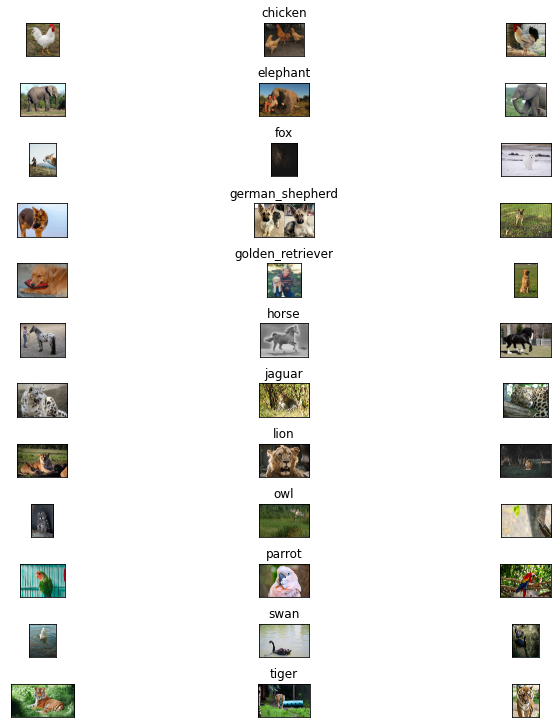

In [8]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

## Step 3: Choosing the descriptor
From the information gathered in step 2, a preffered descriptor and proposed amount of clusters is loaded.

### 3.a: Loading in the pickle data
The "descriptor_desired" and "amount_of_clusters" parameters could benefit from fine-tuning. See inline comment to check wether or not they have been fine-tuned. More details in section: Fine-tuning the input.

The default "createCodebook" helper function is used to cluster the data. This can be optimised later.

In [9]:
# fine-tuning of these parameters has not been done!
descriptor_desired = optima_descriptor
amount_of_clusters = optima_clusters

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- get the wanted features ----------------- 
# Can be optimised later on!
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_clusters)

Number of encoded train images: 4042
Number of encoded test images: 4035
training took 15.416246891021729 seconds


### 3.b: Encoding the images
It's important to note that the test data has to be encoded using the same logic as well!

In [10]:
# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    
# ----------------- make labels numerical ----------------- 
train_labels_text = train_labels[:]

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

print(train_labels_text[:10])
print(train_labels[:10])
    
# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]


### 3.c: Validate loaded data
This step prints some output to check wether or not the previous step succeeded.

In [11]:
# ----------------- print some info ----------------- 
print("Amoount of interesting points available: ", len(train_features_from_pkl[0][2]))
print("Amoount of clusters requested: ", len(train_data[0]))

print("\nTrain labels: ", train_labels[:1])
print("Train data: \n", train_data[:1])

print("\nTest data by Kaggle: \n", test_data_by_kaggle[:1])

Amoount of interesting points available:  500
Amoount of clusters requested:  100

Train labels:  [0]
Train data: 
 [array([0.05029424, 0.05029424, 0.10058849, 0.06705899, 0.08382374,
       0.23470647, 0.0335295 , 0.08382374, 0.11735324, 0.06705899,
       0.05029424, 0.05029424, 0.13411798, 0.13411798, 0.13411798,
       0.0335295 , 0.21794172, 0.08382374, 0.01676475, 0.08382374,
       0.26823597, 0.05029424, 0.01676475, 0.11735324, 0.11735324,
       0.06705899, 0.10058849, 0.10058849, 0.0335295 , 0.11735324,
       0.10058849, 0.06705899, 0.11735324, 0.05029424, 0.        ,
       0.16764748, 0.01676475, 0.05029424, 0.05029424, 0.        ,
       0.18441223, 0.15088273, 0.06705899, 0.13411798, 0.01676475,
       0.01676475, 0.01676475, 0.06705899, 0.01676475, 0.05029424,
       0.05029424, 0.21794172, 0.13411798, 0.10058849, 0.06705899,
       0.0335295 , 0.15088273, 0.08382374, 0.18441223, 0.15088273,
       0.06705899, 0.05029424, 0.08382374, 0.01676475, 0.06705899,
       0.083

## Step 4: Making validation set(s) and test set(s)
As per requirement of the Kaggle compitition, the score on the test data can not be used for optimilisation.
This is logical since the score would then not represent a score on completely unseen data anymore.
This is why we need to split the training data a second time into a training set and a validation set.

This splitting could benefit from fine-tuning.
See inline comment to check wether or not it has been fine-tuned.
It is chosen to take into account the unbalance of the dataset given.
More information in section: Fine-tuning the validation set

In [12]:
# fine-tuning of these parameters has not been done!
test_fraction = optima_test_fraction
balanced = optima_test_fraction_balanced

if balanced:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
else:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)


#validating the split
print("Train labels: ", train_labels_split[:2])
print("\nTrain data: \n", train_data_split[:2])

Train labels:  [8 3]

Train data: 
 [array([0.04280476, 0.07134127, 0.01426825, 0.12841428, 0.12841428,
       0.04280476, 0.01426825, 0.08560952, 0.11414603, 0.        ,
       0.02853651, 0.11414603, 0.07134127, 0.05707301, 0.04280476,
       0.07134127, 0.04280476, 0.05707301, 0.07134127, 0.42804761,
       0.07134127, 0.07134127, 0.        , 0.08560952, 0.07134127,
       0.04280476, 0.04280476, 0.17121904, 0.04280476, 0.08560952,
       0.01426825, 0.04280476, 0.05707301, 0.07134127, 0.07134127,
       0.11414603, 0.11414603, 0.08560952, 0.07134127, 0.12841428,
       0.04280476, 0.01426825, 0.08560952, 0.08560952, 0.08560952,
       0.07134127, 0.01426825, 0.07134127, 0.14268254, 0.01426825,
       0.11414603, 0.04280476, 0.02853651, 0.07134127, 0.08560952,
       0.07134127, 0.05707301, 0.02853651, 0.07134127, 0.        ,
       0.02853651, 0.04280476, 0.12841428, 0.01426825, 0.55646189,
       0.05707301, 0.02853651, 0.09987778, 0.07134127, 0.08560952,
       0.04280476, 0.0998

---

## Step 5: Making the model

### Step 5.a : Better input data

In [39]:
# ------- forcing input data to have equal amount of input
minimum_frequency = Counter(train_labels_split).most_common()[-1][1] 
label_counts = [0]*len(label_strings)
balanced_train_data = []
balanced_train_label = []

for idx in range(len(train_data_split)):
    if label_counts[train_labels_split[idx]] < minimum_frequency:
        balanced_train_data.append(train_data_split[idx])
        balanced_train_label.append(train_labels_split[idx])
        label_counts[train_labels_split[idx]] += 1

In [40]:
svc_train_data = balanced_train_data
svc_train_label = balanced_train_label


In [41]:
# edit to the optimals for SVC
optima_C_svc = 6
optima_gamma_svc = 0.01 # no difference
optima_shrinking_svc = True
optima_tol_svc = 0.001
optima_class_weight_svc = 'balanced'
optima_probability_svc = True
optima_cache_size_svc = 5000
optima_kernel_svc = 'rbf'

# step 1: import the model
from sklearn.svm import SVC

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)


model = make_pipeline(StandardScaler(),
                      SVC(C=optima_C_svc,
                          gamma = optima_gamma_svc,
                          kernel = optima_kernel_svc,
                          shrinking = optima_shrinking_svc,
                          tol = optima_tol_svc,
                          class_weight = optima_class_weight_svc,
                          probability=optima_probability_svc,
                          cache_size = optima_cache_size_svc))

# step 3: train the model on the training data

model.fit(svc_train_data, svc_train_label)

# step 4: predict labels for test data 

predictions_train = model.predict(svc_train_data)
predictions_probability_train = model.predict_proba(svc_train_data)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# step 4: calculate the accuracy of the model on the train set and on the test set
# We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

train_score = log_loss(svc_train_label, predictions_probability_train)
test_score = log_loss(test_labels_split, predictions_probability_test)

folds = StratifiedKFold(n_splits=5, shuffle=True)
scores_cross = - cross_val_score(model, train_data, train_labels, cv=folds, scoring='neg_log_loss')
score_cross = scores_cross.mean()

print("Accuracy of model (single log_loss): ",train_score," (train), ",test_score," (test)")
print("Accuracy of model (cross-fold log_loss): ",score_cross)

Accuracy of model (single log_loss):  0.4871939768636256  (train),  1.7002339232478876  (test)
Accuracy of model (cross-fold log_loss):  1.4834515088161786


---

## Step 6: analysing the model

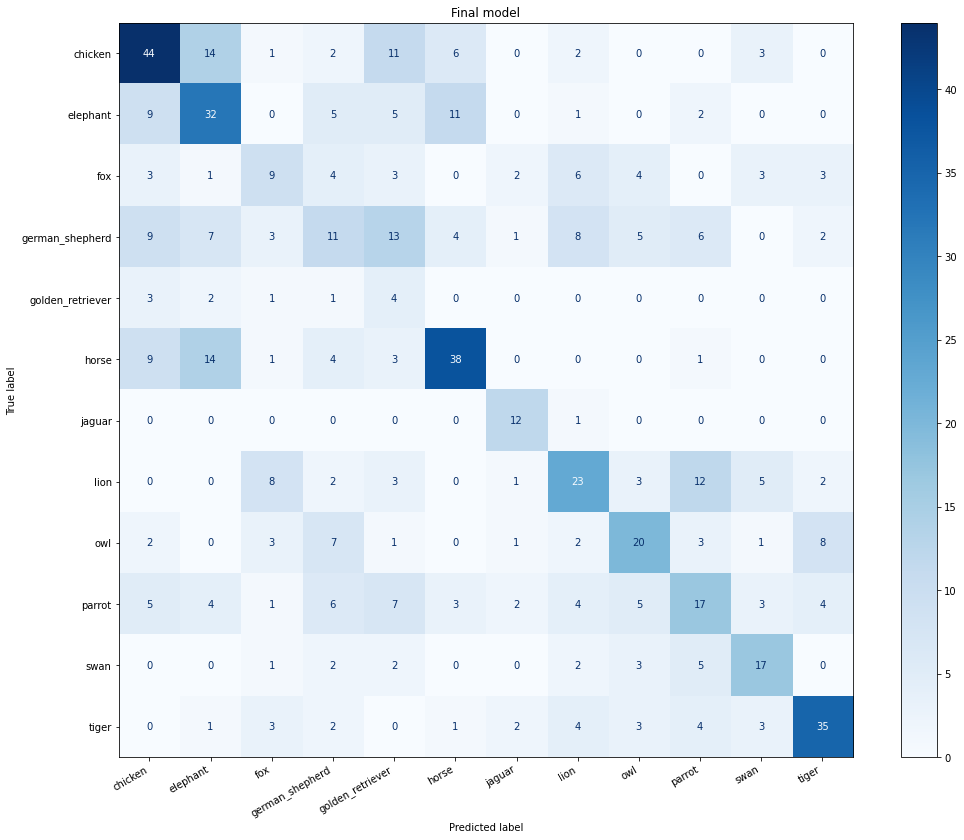

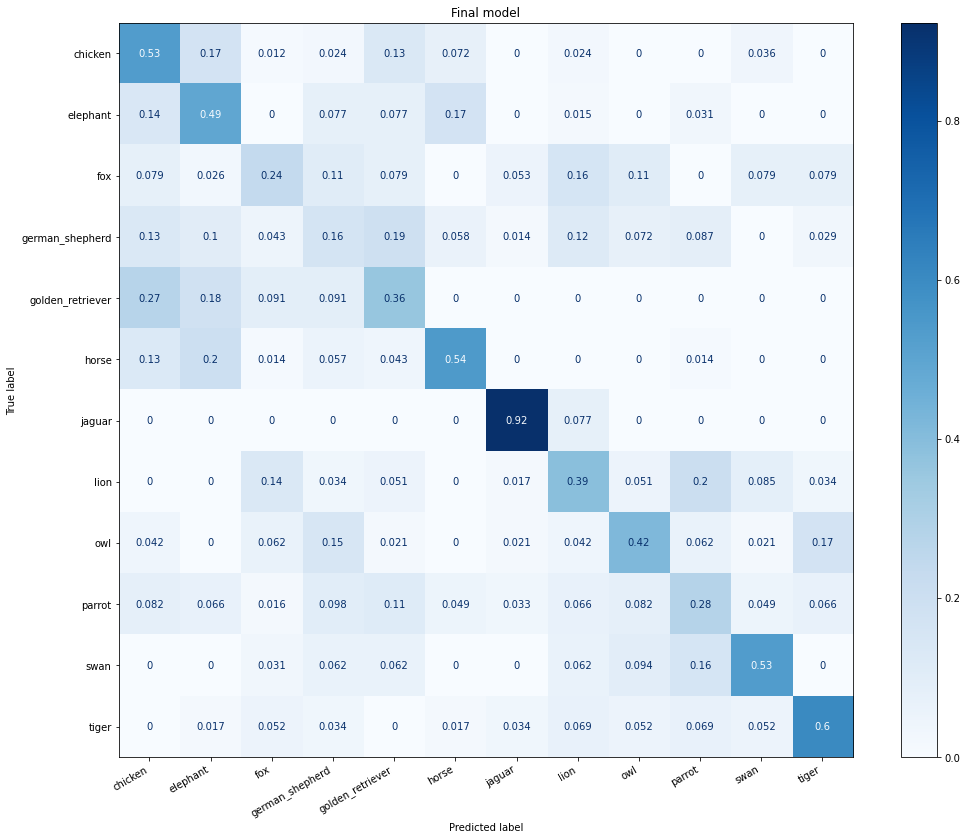

In [42]:
title = "Final model"

# make plot bigger
plt.rcParams['figure.figsize'] = 17, 15

# Plot non-normalized confusion matrix
np.set_printoptions(precision=2)

disp = plot_confusion_matrix(model, test_data_split, test_labels_split,
                             display_labels=label_strings,
                             cmap=plt.cm.Blues,
                             normalize=None)
disp.ax_.set_title(title)
disp.figure_.autofmt_xdate()

plt.savefig("../graphs/final/final_cm", dpi=300, bbox_inches='tight')
plt.show()

# ---------------------------------------------

# Plot normalized confusion matrix
np.set_printoptions(precision=2)

disp = plot_confusion_matrix(model, test_data_split, test_labels_split,
                             display_labels=label_strings,
                             cmap=plt.cm.Blues,
                             normalize='true')
disp.ax_.set_title(title)
disp.figure_.autofmt_xdate()

plt.savefig("../graphs/final/final_cm_normalised", dpi=300, bbox_inches='tight')
plt.show()

# reset plot size
plt.rcParams.update(plt.rcParamsDefault)

---

## Step 6: Generating CSV for submission

In [ ]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('2/support_vector_machine', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)